In [64]:
from functools import partial
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
import cv2

import sys
sys.path.append('/home/oscar_palfelt/MSc_thesis/ompl/py-bindings')
from ompl import base as ob
from ompl import control as oc
from ompl import geometric as og

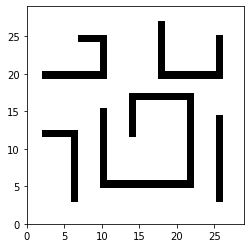

In [96]:
# Load obstacle data
filename = '/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/motion_planning/data_generation/map_difficult.png'
occGrid = np.clip(cv2.imread(filename, 0), 0, 1)
gridSize = occGrid.shape[0]
plt.imshow(occGrid, extent=[0, gridSize-1, 0, gridSize-1], cmap='gray')
plt.show()

In [127]:
# define planning problem

def isStateValid(spaceInformation, state):
    # perform collision checking or check if other constraints are
    # satisfied
    u = int(np.floor(state.getX() * occGrid.shape[1])) # right pointing image axis
    v = int(np.floor(occGrid.shape[0] * (1 - state.getY()))) # down pointing image axis

    if spaceInformation.satisfiesBounds(state):
        return occGrid[v,u] > 0


def problemDef():
    # construct the state space we are planning in
    #space = ob.DubinsStateSpace(turningRadius=0.1)
    space = ob.SE2StateSpace()

    # set the bounds for the R^2 part of SE(2)
    bounds = ob.RealVectorBounds(2)
    bounds.setLow(0.001)
    bounds.setHigh(0.999)
    space.setBounds(bounds)

    # define a simple setup class
    ss = og.SimpleSetup(space)
    ss.setStateValidityChecker(ob.StateValidityCheckerFn( \
        partial(isStateValid, ss.getSpaceInformation())))

    si = ss.getSpaceInformation()
    planner = og.RRTstar(si)
    ss.setPlanner(planner)

    

    return ss


def plan(planObj, initState, goalState):

    #space = ob.DubinsStateSpace(turningRadius=0.1)
    space = ob.SE2StateSpace()
    
    start = ob.State(space)
    start().setX(initState[0])
    start().setY(initState[1])
    start().setYaw(initState[2])

    goal = ob.State(space)
    goal().setX(goalState[0])
    goal().setY(goalState[1])
    goal().setYaw(goalState[2])
    
    planObj.setStartAndGoalStates(start, goal, 0.1)

    #timeTerminationCondition = ob.timedPlannerTerminationCondition(8.0)
    exactSolTerminationCondition = ob.exactSolnPlannerTerminationCondition(planObj.getProblemDefinition())
    #costTerminationCondition = ob.CostConvergenceTerminationCondition(planObj.getProblemDefinition(), epsilon=0.5)
    #andTerminationCondition = ob.plannerOrTerminationCondition(exactSolTerminationCondition, timeTerminationCondition)

    planObj.solve(exactSolTerminationCondition)

In [128]:
# generate planning data, car scenario

nData = 10 # number of plans to generate

minDistThreshold = 0.5 # minimum distance threshold betwen start/goal

trajSamples = np.zeros(shape=(1, 4)) # x, y, xdot, ydot
newInitData = np.zeros(shape=(1, 4)) # x, y, xdot, ydot
newGoalData = np.zeros(shape=(1, 4))

planObj = problemDef()

plotPaths = True
i = 0 
nPlans = 0 # number of completed plans
while nPlans < nData:

    start = np.array([0, 0, 0]) # x, y, yaw
    goal  = np.copy(start)
    ux = 0; vx = 0; uy = 0; vy = 0
    
    while np.linalg.norm(start[:2] - goal[:2]) < minDistThreshold and occGrid[vx,ux] > 0 and occGrid[vy,uy] > 0:
        start = np.array([np.random.uniform(low=0.001, high=0.999), np.random.uniform(low=0.001, high=0.999), np.random.uniform(low=-np.pi, high=np.pi)])
        goal  = np.array([np.random.uniform(low=0.001, high=0.999), np.random.uniform(low=0.001, high=0.999), np.random.uniform(low=-np.pi, high=np.pi)])
        ux = int(np.floor(start[0] * gridSize)) # right pointing image axis
        vx = int(np.floor(gridSize * (1 - start[1]))) # down pointing image axis
        uy = int(np.floor(goal[0] * gridSize)) # right pointing image axis
        vy = int(np.floor(gridSize * (1 - goal[1]))) # down pointing image axis

    print("started planning")
    plan(planObj, start, goal)

    print(planObj.getProblemDefinition().hasExactSolution())
    if planObj.getProblemDefinition().hasExactSolution():

        sol = np.loadtxt(StringIO(planObj.getSolutionPath().printAsMatrix()))
        nSamples = sol.shape[0]

        xdot = np.cos(sol[:,2]).reshape((nSamples,1))
        ydot = np.sin(sol[:,2]).reshape((nSamples,1))
        trajSamples = np.vstack((trajSamples, np.hstack((sol[:, 0:2], xdot, ydot)))) # x, y, xdot, ydot
        newInitData = np.vstack((newInitData, np.tile(np.append(start[0:2], [np.cos(start[-1]), np.sin(start[-1])]), reps=(nSamples, 1)))) # x, y, yaw, xdot, ydot
        newGoalData = np.vstack((newGoalData, np.tile(np.append(goal[0:2], [np.cos(goal[-1]), np.sin(goal[-1])]), reps=(nSamples, 1)))) # x, y, yaw, xdot, ydot
        
        if plotPaths:
            fig, ax = plt.subplots()
            ax.imshow(occGrid, extent=[0, gridSize-1, 0, gridSize-1], cmap='gray')
            ax.scatter(start[0] * (gridSize - 1), start[1] * (gridSize - 1), color="red", s=250, edgecolors='black')
            ax.scatter(goal[0] * (gridSize - 1), goal[1] * (gridSize - 1), color="blue", s=250, edgecolors='black')
            ax.scatter(sol[:, 0] * (gridSize - 1), sol[:, 1] * (gridSize - 1), color="green", s=50, alpha=0.7)
            plt.show()

        nPlans += 1
        if nPlans % 10 == 0:
            print('\n nPlans {}\n'.format(nPlans))
  
    # planObj.clear()
    # planObj.getProblemDefinition().clearSolutionPaths()
    # planObj.getProblemDefinition().clearGoal()
    # planObj.getProblemDefinition().clearStartStates()
    i += 1  

    #ob.ProblemDefinition.getSolution

newData = np.concatenate((trajSamples, newInitData, newGoalData), axis=1)[1:]
np.savetxt('/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/motion_planning/data/pathDataDifficult', newData, delimiter=',', fmt='%1.6f')


started planning
